In [1]:
from ranx import Run, evaluate, fuse
import numpy as np

In [2]:
import joblib

search_results_with_target = joblib.load("../workdir/rerank_ws/search_results.pkl.gz")
# search_results_with_target = joblib.load(
#     "../workdir/rerank_ws/search_results_debug.pkl.gz"
# )

In [3]:
target_dataset_name = "aio_01_test"

In [4]:
search_results = search_results_with_target[target_dataset_name]

In [5]:
len(search_results)

3

In [6]:
search_results[0]["indexes"].shape

(2000, 500)

In [7]:
jacket_size = search_results[0]["indexes"].shape[0]
jacket_size

2000

In [8]:
runs = []
for search_result in search_results:
    name = search_result["name"]
    print(name)
    scores = search_result["scores"]
    # score が高いほど良い、にするために反転
    scores = np.abs(search_result["scores"] - 1.0)
    indexes = search_result["indexes"]
    qids = search_result["qids"]
    run_dict = {}
    for id, score, index in zip(qids, scores, indexes):
        # id = str(id)
        # score = score.tolist()
        # index = index.tolist()
        index_score_dict = {}
        for s, pid in zip(score, index):
            index_score_dict[str(pid)] = s
        run_dict[id] = index_score_dict
    run = Run(run_dict, name=name)
    runs.append(run)

intfloat/multilingual-e5-large
cl-nagoya/sup-simcse-ja-base
pkshatech/GLuCoSE-base-ja


In [9]:
combined_run = fuse(
    runs=runs,  # A list of Run instances to fuse
    norm="min-max",  # The normalization strategy to apply before fusion
    method="rrf",  # The fusion algorithm to use
)

In [10]:
combined_data = combined_run.to_dict()

In [11]:
len(combined_data)

2000

In [12]:
len(combined_data["0"])

0

In [13]:
import json
import os
import re
import time
import urllib.request
from argparse import ArgumentParser
from dataclasses import dataclass
from functools import lru_cache
from pathlib import Path
from time import time

import faiss
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset  # type: ignore
from tqdm import tqdm


WIKIPEDIA_JA_DS = "singletongue/wikipedia-utils"
WIKIPEDIA_JS_DS_NAME = "passages-c400-jawiki-20230403"
WIKIPEDIA_JA_EMB_DS = "hotchpotch/wikipedia-passages-jawiki-embeddings"


def get_wikija_ds(name: str = WIKIPEDIA_JS_DS_NAME):
    ds = load_dataset(path=WIKIPEDIA_JA_DS, name=name, split="train")  # type: ignore
    return ds


# jaqket v1
@dataclass
class JaqketQuestionV1:
    qid: str
    question: str
    answer_entity: str
    label: int
    answer_candidates: list[str]
    original_question: str


print("load wikija datasets")
ds = get_wikija_ds()

jaqket_ds = load_dataset("hotchpotch/jaqket_cc")[target_dataset_name]

load wikija datasets


In [14]:
jaqket_ds = jaqket_ds.select(range(jacket_size))

In [15]:
found_indexes = []
for jaqket in jaqket_ds:
    qid = jaqket["qid"]
    # print("")
    # print(jacket.question)
    # print(jacket.answer_entity)
    found_index = -1
    rank_data = combined_data[qid]
    answers = jaqket["answers"]
    for rank_idx, (k, v) in enumerate(rank_data.items()):
        ds_index = int(k)
        target_data = ds[ds_index]
        join_text = target_data["title"] + target_data["text"]
        for answer in answers:
            if answer in join_text:
                found_index = rank_idx
                break
        if found_index != -1:
            break
    found_indexes.append(found_index)

In [16]:
# index が -1の要素を数える
print(len([i for i in found_indexes if i == -1]))

14


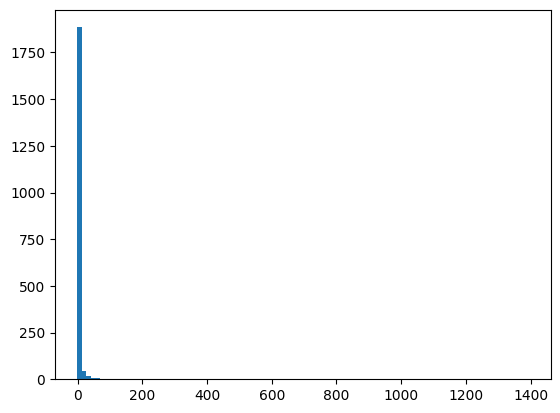

In [17]:
# plt hist
import matplotlib.pyplot as plt

plt.hist(found_indexes, bins=100)
plt.show()

In [18]:
# pd
import pandas as pd

# percentile

pd.Series(found_indexes).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.85, 0.9])

count    2000.000000
mean        7.724000
std        56.697461
min        -1.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
85%         4.000000
90%         7.000000
max      1393.000000
dtype: float64

In [19]:
# ds の正解ラベルを取得

acc_labels_dict = {}
for jaqket in jaqket_ds:
    qid = jaqket["qid"]
    answers = jaqket["answers"]
    rank_data = combined_data[qid]
    acc_labels = {}
    for rank_idx, (pid, v) in enumerate(rank_data.items()):
        ds_index = int(pid)
        target_data = ds[ds_index]
        join_text = target_data["title"] + " " + target_data["text"]
        for answer in answers:
            if answer in join_text:
                acc_labels[pid] = 1
    acc_labels_dict[qid] = acc_labels

In [20]:
list(runs[0]["QA20CAPR-1004"].items())[0:10]

[('60221', 0.7589395046234131),
 ('5191928', 0.7540072798728943),
 ('60220', 0.7327320575714111),
 ('49522', 0.7222505807876587),
 ('28979', 0.7185056209564209),
 ('221102', 0.7161310911178589),
 ('3931012', 0.7156597375869751),
 ('1953461', 0.7128769159317017),
 ('56160', 0.7128099203109741),
 ('298370', 0.7118792533874512)]

In [21]:
list(runs[1]["QA20CAPR-1004"].items())[0:10]

[('5191928', 0.6499424576759338),
 ('60222', 0.6079654693603516),
 ('60221', 0.6046477556228638),
 ('1459483', 0.579555332660675),
 ('1767473', 0.5744842886924744),
 ('1912169', 0.5723570585250854),
 ('220168', 0.5538879632949829),
 ('1953461', 0.5487591028213501),
 ('57209', 0.5454388856887817),
 ('2665789', 0.5444353818893433)]

In [22]:
list(acc_labels_dict["QA20CAPR-1002"].items())[0:10]

[('2548662', 1),
 ('4265351', 1),
 ('4265355', 1),
 ('3805776', 1),
 ('4265358', 1),
 ('3805775', 1),
 ('3805777', 1),
 ('4181190', 1),
 ('4265359', 1),
 ('4265360', 1)]

In [23]:
from ranx import evaluate, Qrels

qrels = Qrels(acc_labels_dict)

In [24]:
evaluate(qrels, runs[0], "ndcg@100")

0.42149081510092434

In [25]:
runs[0].name, evaluate(qrels, runs[0], "hit_rate@100")

('intfloat/multilingual-e5-large', 0.978)

In [46]:
from ranx import compare

# Compare different runs and perform statistical tests
report = compare(
    qrels=qrels,
    runs=runs,
    metrics=[
        #         "map@10",
        "map@10",
        "mrr@10",
        "ndcg@10",
        "ndcg@100",
        "precision@10",
        "precision@100",
        "hit_rate@1",
        "hit_rate@5",
        "hit_rate@10",
        "hit_rate@20",
        #        "hit_rate@50",
        "hit_rate@100",
        "hit_rate@500",
    ],
    max_p=0.01,  # P-value threshold
)
print(report.to_table())

#    Model                           MAP@10    MRR@10    NDCG@10    NDCG@100    P@10     P@100    Hit Rate@1    Hit Rate@5    Hit Rate@10    Hit Rate@20    Hit Rate@100    Hit Rate@500
---  ------------------------------  --------  --------  ---------  ----------  -------  -------  ------------  ------------  -------------  -------------  --------------  --------------
a    intfloat/multilingual-e5-large  0.124ᵇᶜ   0.789ᵇᶜ   0.492ᵇᶜ    0.421ᵇᶜ     0.416ᵇᶜ  0.162ᵇᶜ  0.706ᵇᶜ       0.902ᵇᶜ       0.936ᵇᶜ        0.956ᵇᶜ        0.978ᵇᶜ         0.989ᵇᶜ
b    cl-nagoya/sup-simcse-ja-base    0.066ᶜ    0.566ᶜ    0.308ᶜ     0.274ᶜ      0.257ᶜ   0.113ᶜ   0.461ᶜ        0.707ᶜ        0.786          0.843          0.927           0.974
c    pkshatech/GLuCoSE-base-ja       0.052     0.521     0.269      0.230       0.226    0.093    0.410         0.676         0.767          0.833          0.927           0.974


In [47]:
from ranx import fuse, evaluate, optimize_fusion

target_metric = "precision@100"
# Optimize a given fusion method
best_params = optimize_fusion(
    qrels=qrels,
    runs=runs,
    norm="min-max",  # Default value
    method="wsum",  # Alias for Weighted Sum
    metric=target_metric,  # Metric we want to maximize
)

combined_run = fuse(
    runs=runs,
    norm="min-max",  # Default value
    method="wsum",  # Alias for Weighted Sum
    params=best_params,
)

print(combined_run.name, evaluate(qrels, combined_run, target_metric))

Output()

weighted_sum 0.16657999999999998


In [48]:
# combined_run.keys()["0"]
""

''

In [49]:
from ranx import compare

# Compare different runs and perform statistical tests
report = compare(
    qrels=qrels,
    runs=[combined_run],
    metrics=[
        #         "map@10",
        "map@10",
        "mrr@10",
        "ndcg@10",
        "ndcg@100",
        "precision@10",
        "precision@100",
        "hit_rate@1",
        "hit_rate@5",
        "hit_rate@10",
        "hit_rate@20",
        #        "hit_rate@50",
        "hit_rate@100",
        "hit_rate@500",
    ],
    max_p=0.01,  # P-value threshold
)
print(report.to_table())

#    Model           MAP@10    MRR@10    NDCG@10    NDCG@100    P@10    P@100    Hit Rate@1    Hit Rate@5    Hit Rate@10    Hit Rate@20    Hit Rate@100    Hit Rate@500
---  ------------  --------  --------  ---------  ----------  ------  -------  ------------  ------------  -------------  -------------  --------------  --------------
a    weighted_sum     0.129     0.794      0.502       0.433   0.423    0.167          0.71         0.909          0.938          0.959           0.979            0.99


In [50]:
combined_data = combined_run.to_dict()

In [51]:
combined_keys = list(combined_data.keys())  # [0:10]

In [52]:
jaqket_dict = {}
for jaqket in jaqket_ds:
    qid = jaqket["qid"]
    jaqket_dict[qid] = jaqket

In [53]:
qrels_dict = {}
for key in combined_keys:
    data = combined_data[key]
    jaqket = jaqket_dict[key]
    qid = jaqket["qid"]
    question = jaqket["question"]
    answers = jaqket["answers"]
    # print("-------")
    # print(question)
    # print(answers)
    results = {}
    for k, v in list(data.items())[0:100]:
        jid = str(k)
        d = ds[int(k)]
        title = d["title"]
        text = title + " " + d["text"]
        label = 0
        for answer in answers:
            if answer in text:
                label = 1
        if label == 1:
            results[jid] = label
    qrels_dict[qid] = results

In [54]:
len(qrels_dict)

2000

In [55]:
qrels_2 = Qrels(qrels_dict)

In [56]:
# combined_run.__class__
# acc_labels_dict

In [57]:
# qrels_dict

In [59]:
evaluate(qrels_2, combined_run, "hit_rate@100", make_comparable=True)

0.9785